# Preprocessing of Dataset

The existing dataset contains raw satelite imagery with dimensions and proportions which fail to fit the requirements of the model. This notebook will preprocess the data into 7 chunks of data representing random crops of the weather patterns over the UK. Crops are restricted to daylight hours only, from 10:00 AM - 3:55 PM.

In [14]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
from tqdm import tqdm
import torch
import pathlib

plt.rcParams["figure.figsize"] = (20, 12)

In [15]:
SATELLITE_ZARR_PATH = "eumetsat_seviri_hrv_uk.zarr"

dataset = xr.open_dataset(
    SATELLITE_ZARR_PATH, 
    engine="zarr",
    chunks="auto",  # Load the data as a Dask array
)

The extent of the UK in this map is $[500,1012] \times [300,812]$, which is a 512 x 512 region. Therefore random crop will be pulled from mainly within this area.

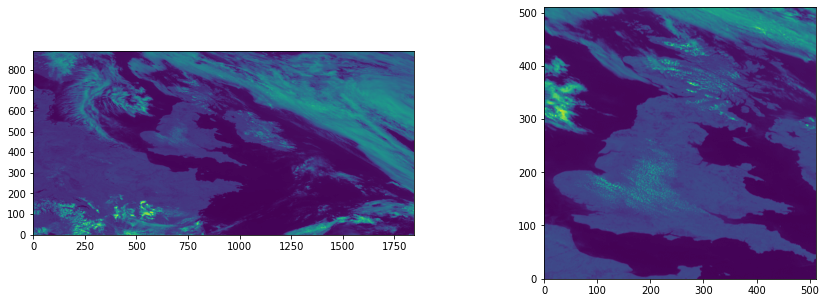

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].imshow(dataset["data"].sel(time="2020-06-01 12:00").to_numpy(), cmap='viridis', origin='lower')
ax[1].imshow(dataset["data"].sel(time="2020-06-01 12:00").isel(x=slice(500, 1012), y=slice(300, 812)).to_numpy(), cmap='viridis', origin='lower')

On the left is the whole satelite image, and on the right is the 512 by 512 crop from which the images of weather over the UK will be pulled.

Here is the procedure:
1. For each 3 hr period per day
    1. Select 5 random centers in the region $[628, 884] \times [428,684]$
    2. Crop the 128 x 128 region around that center to get the input sequence
    3. Crop the 64 x 64 region around that center to get the output sequence

However, pulling these from the `xarray` dataset is slow (1 min, 30 sec) per draw. Therefore a preprocessing step to PyTorch binaries is added.

Starting on February 2nd, 2020, the following pattern is used to process blocks of data:
1. Start at 10:00 AM every morning.
2. Select the the next 6 hours of satelite imagery and write to file (to avoid overloading RAM). Each of these blocks rounds out to ~37 MB.
2. Skip forward to next day and repeat until all days are exhausted. This corresponds to selecting ~596 days worth of imagery, and a total of ~21 GB of data of the total uncompressed ~500 GB of data. The decrease in size is attributed to selecting only the 512 x 512 region of each image.

In [42]:
def generate_blocks(path: pathlib.Path, start_time:int, skip_time:int, selection_region:int):
    if not path.exists():
        path.mkdir(parents=True)
    idx = 1 
    for i in tqdm(range(start_time, 173264, skip_time)):
        block = dataset.isel(time=slice(i, i + selection_region), x=slice(500, 1012), y=slice(300, 812)).to_array().to_numpy()
        newpath = path / f"block{idx}.npy"
        torch.save(newpath, torch.from_numpy(block))
        idx += 1
        del block


path = pathlib.Path("./temp/processed/")
start_time = 1847
skip_time = 288
selection_region = 72

generate_blocks(path, start_time, skip_time, selection_region)

100%|██████████| 596/596 [51:11<00:00,  5.15s/it]  


Each of these batches are then loaded by `infra.ClimateHackDataset`, randomly cropped, and presented to the user.

In [10]:
from infra.dataset import ClimateHackDataset
dl = torch.utils.data.DataLoader(ClimateHackDataset("./temp/processed"))
it = iter(dl)
next(it)
x,y = next(it)

Loading the input sequence below

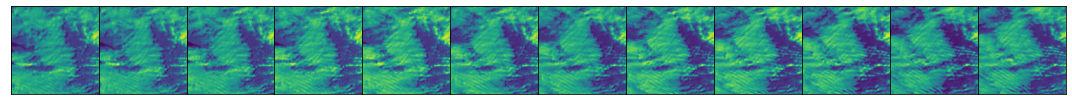

In [12]:
fig, ax = plt.subplots(1, 12, figsize=(15,5))
for i in range(12):
    ax[i].imshow(x[0,i,:,:], cmap='viridis')
    ax[i].get_xaxis().set_visible(False)
    ax[i].get_yaxis().set_visible(False)

fig.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0)

And visualizing the corresponding output sequence below

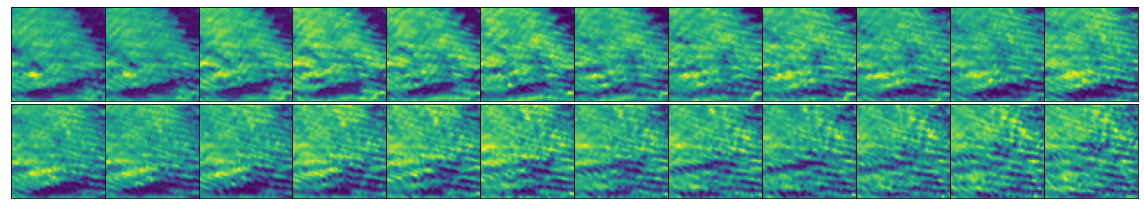

In [13]:
fig, (ax1, ax2) = plt.subplots(2, 12, figsize=(16,3))
for i in range(12):
    ax1[i].imshow(y[0,i,:,:], cmap='viridis')
    ax1[i].get_xaxis().set_visible(False)
    ax1[i].get_yaxis().set_visible(False)

for i in range(12):
    ax2[i].imshow(y[0,12+i,:,:], cmap='viridis')
    ax2[i].get_xaxis().set_visible(False)
    ax2[i].get_yaxis().set_visible(False)

fig.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0)